In [1]:
import os
import torch
import pandas as pd
import scanpy as sc

In [2]:
from SpatialGlue import SpatialGlue

In [3]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = r'C:\Users\AGNISH\.conda\envs\SpatialGlue\Lib\R'

# fix random seed
from SpatialGlue.preprocess import fix_seed
random_seed=2022
fix_seed(random_seed)

In [4]:
# the number of clusters
n_clusters = 8

In [5]:
# read data
file_fold = 'C:/Users/AGNISH/Desktop/IITK/VSCode/SpatialGlue/Data/Mouse_Thymus/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

In [6]:
adata_omics1

AnnData object with n_obs × n_vars = 4697 × 23622
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'

In [7]:
adata_omics2

AnnData object with n_obs × n_vars = 4697 × 51
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'

In [8]:
from SpatialGlue.preprocess import preprocessing
data = preprocessing(adata_omics1, adata_omics2, datatype='Stereo-CITE-seq')

c:\Users\AGNISH\.conda\envs\SpatialGlue\lib\site-packages\scanpy\preprocessing\_pca.py:229: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm['X_pca'] = X_pca


In [9]:
adata_omics1 = data['adata_omics1']
adata_omics2 = data['adata_omics2']

In [10]:
from SpatialGlue.utils import clustering

# clustering
clustering(adata_omics1, key='feat', add_key='RNA', n_clusters=n_clusters)
clustering(adata_omics2, key='feat', add_key='protein', n_clusters=n_clusters)

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [11]:
import numpy as np
# flip tissue image
adata_omics1.obsm['spatial'][:,1] = -1*adata_omics1.obsm['spatial'][:,1]
adata_omics2.obsm['spatial'][:,1] = -1*adata_omics2.obsm['spatial'][:,1]

c:\Users\AGNISH\.conda\envs\SpatialGlue\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\AGNISH\.conda\envs\SpatialGlue\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\AGNISH\.conda\envs\SpatialGlue\lib\site-packages\umap\distances.py:1086: 

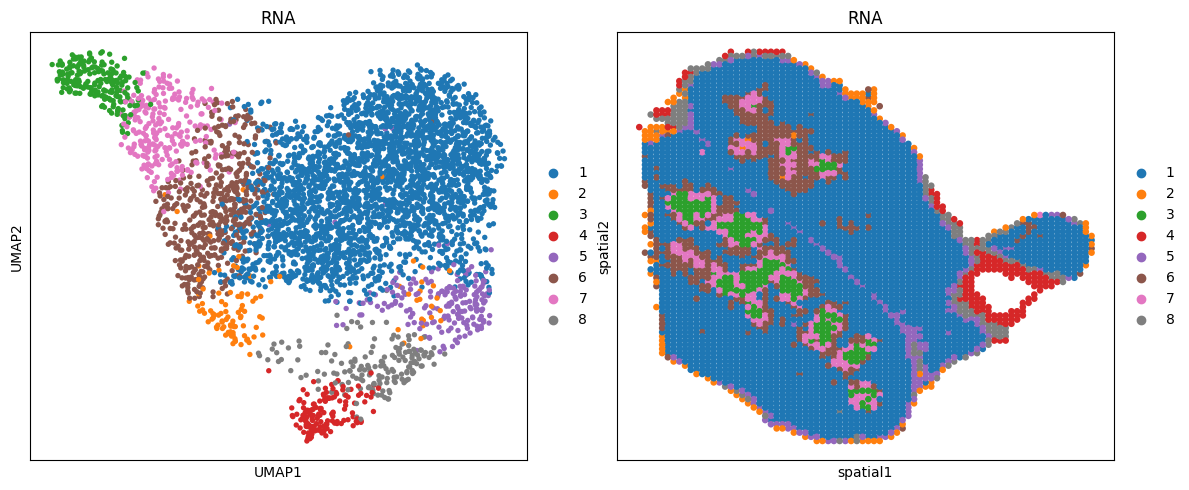

In [12]:
# visualization
import matplotlib.pyplot as plt

# mRNA
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_omics1, use_rep='feat', n_neighbors=10)
sc.tl.umap(adata_omics1)

sc.pl.umap(adata_omics1, color='RNA', ax=ax_list[0], title='RNA', s=60, show=False)
sc.pl.embedding(adata_omics1, basis='spatial', color='RNA', ax=ax_list[1], title='RNA', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

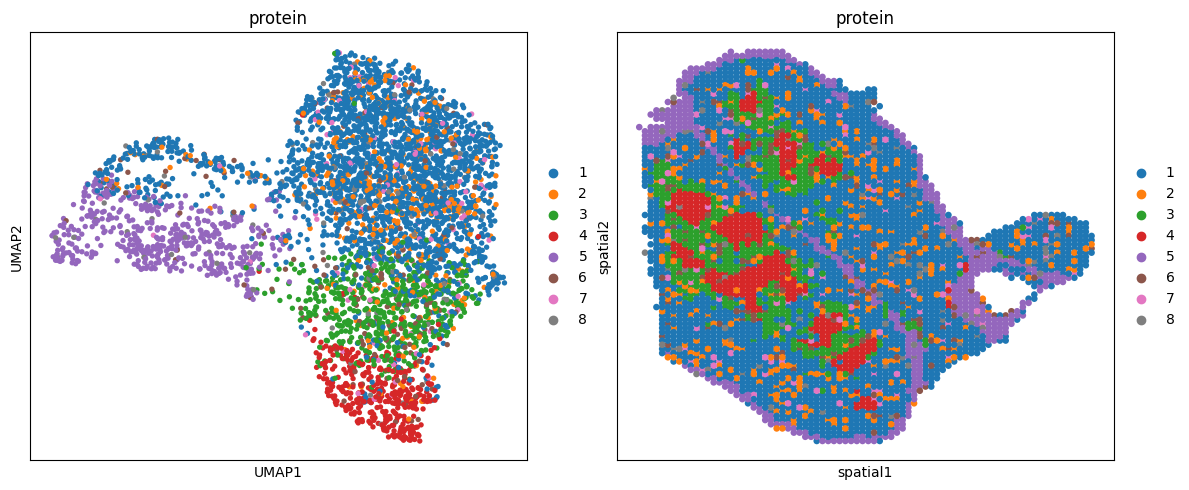

In [13]:
# protein
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_omics2, use_rep='feat', n_neighbors=10)
sc.tl.umap(adata_omics2)

sc.pl.umap(adata_omics2, color='protein', ax=ax_list[0], title='protein', s=60, show=False)
sc.pl.embedding(adata_omics2, basis='spatial', color='protein', ax=ax_list[1], title='protein', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [14]:
# define model
model = SpatialGlue.SpatialGlue(data, datatype='Stereo-CITE-seq', device=device)

# train model
output = model.train()

  0%|          | 0/1500 [00:00<?, ?it/s]c:\Users\AGNISH\.conda\envs\SpatialGlue\lib\site-packages\SpatialGlue\model.py:167: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|██████████| 1500/1500 [03:53<00:00,  6.42it/s]


Model training finished!



In [15]:
output.keys()

dict_keys(['emb_latent_omics1', 'emb_latent_omics2', 'emb_latent_combined', 'alpha_omics1', 'alpha_omics2', 'alpha'])

In [16]:
adata_combined = adata_omics1.copy()
adata_combined.obsm['emb_latent_omics1'] = output['emb_latent_omics1']
adata_combined.obsm['emb_latent_omics2'] = output['emb_latent_omics2']
adata_combined.obsm['emb_latent_combined'] = output['emb_latent_combined']

In [17]:
# we use mcluster as clustering tool by default.
tool = 'mclust' # mclust, leiden, and louvain

# performing PCA
adata_combined.obsm['emb_combined_pca'] = sc.tl.pca(adata_combined.obsm['emb_latent_combined'], n_comps=20)

# clustering
if tool == 'mclust':
   clustering(adata_combined, key='emb_combined_pca', add_key='SpatialGlue', n_clusters=n_clusters, method=tool)
elif tool in ['leiden', 'louvain']:
   clustering(adata_combined, key='emb_combined_pca', add_key='SpatialGlue', n_clusters=n_clusters, method=tool, start=0.1, end=2.0, increment=0.01)

fitting ...
  |======================================================================| 100%


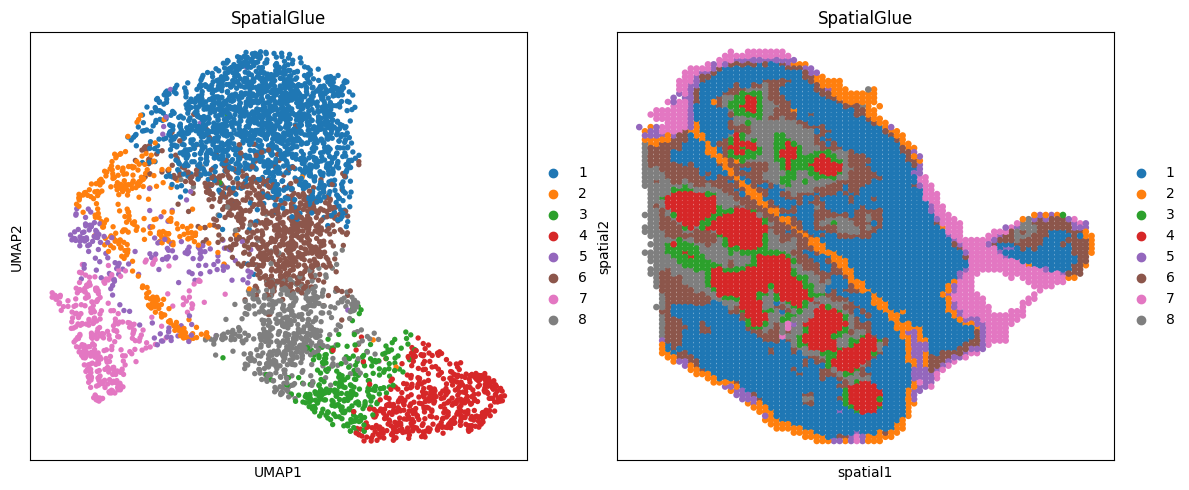

In [18]:
# visualization
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_combined, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(adata_combined)

sc.pl.umap(adata_combined, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [19]:
# annotation
adata_combined.obs['SpatialGlue'].cat.rename_categories({1: 'Outer cortex region 3(DN T,DP T,cTEC)',
                                                   2: 'Subcapsular zone(DN T)',
                                                   3: 'Middle cortex region 2(DN T,DP T,cTEC)',
                                                   4: 'Corticomedullary Junction(CMJ)',
                                                   5: 'Medulla(SP T,mTEC,DC)',
                                                   6: 'Connective tissue capsule(fibroblast,RBC,myeloid)',
                                                   7: 'Connective tissue capsule(fibroblast)',
                                                   8: 'Inner cortex region 1(DN T,DP T,cTEC)'
                                                   }, inplace=True)

C:\Users\AGNISH\AppData\Local\Temp\ipykernel_4956\4088070518.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata_combined.obs['SpatialGlue'].cat.rename_categories({1: 'Outer cortex region 3(DN T,DP T,cTEC)',


In [20]:
list_ = ['Inner cortex region 1(DN T,DP T,cTEC)', 'Corticomedullary Junction(CMJ)',  'Middle cortex region 2(DN T,DP T,cTEC)',
         'Subcapsular zone(DN T)', 'Outer cortex region 3(DN T,DP T,cTEC)',  'Connective tissue capsule(fibroblast,RBC,myeloid)',
         'Medulla(SP T,mTEC,DC)', 'Connective tissue capsule(fibroblast)',
           ]
adata_combined.obs['SpatialGlue']  = pd.Categorical(adata_combined.obs['SpatialGlue'],
                      categories=list_,
                      ordered=True)

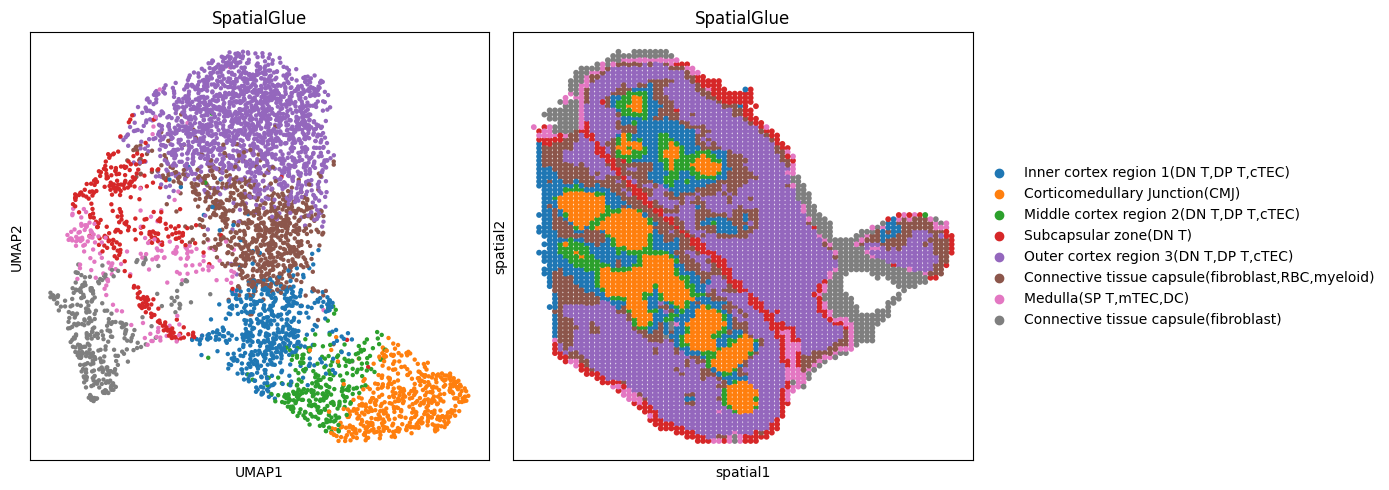

In [21]:
# plotting with annotation
fig, ax_list = plt.subplots(1, 2, figsize=(14, 5))
sc.pp.neighbors(adata_combined, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(adata_combined)

sc.pl.umap(adata_combined, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=40, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=70, show=False)

ax_list[0].get_legend().remove()

plt.tight_layout(w_pad=0.3)
plt.show()

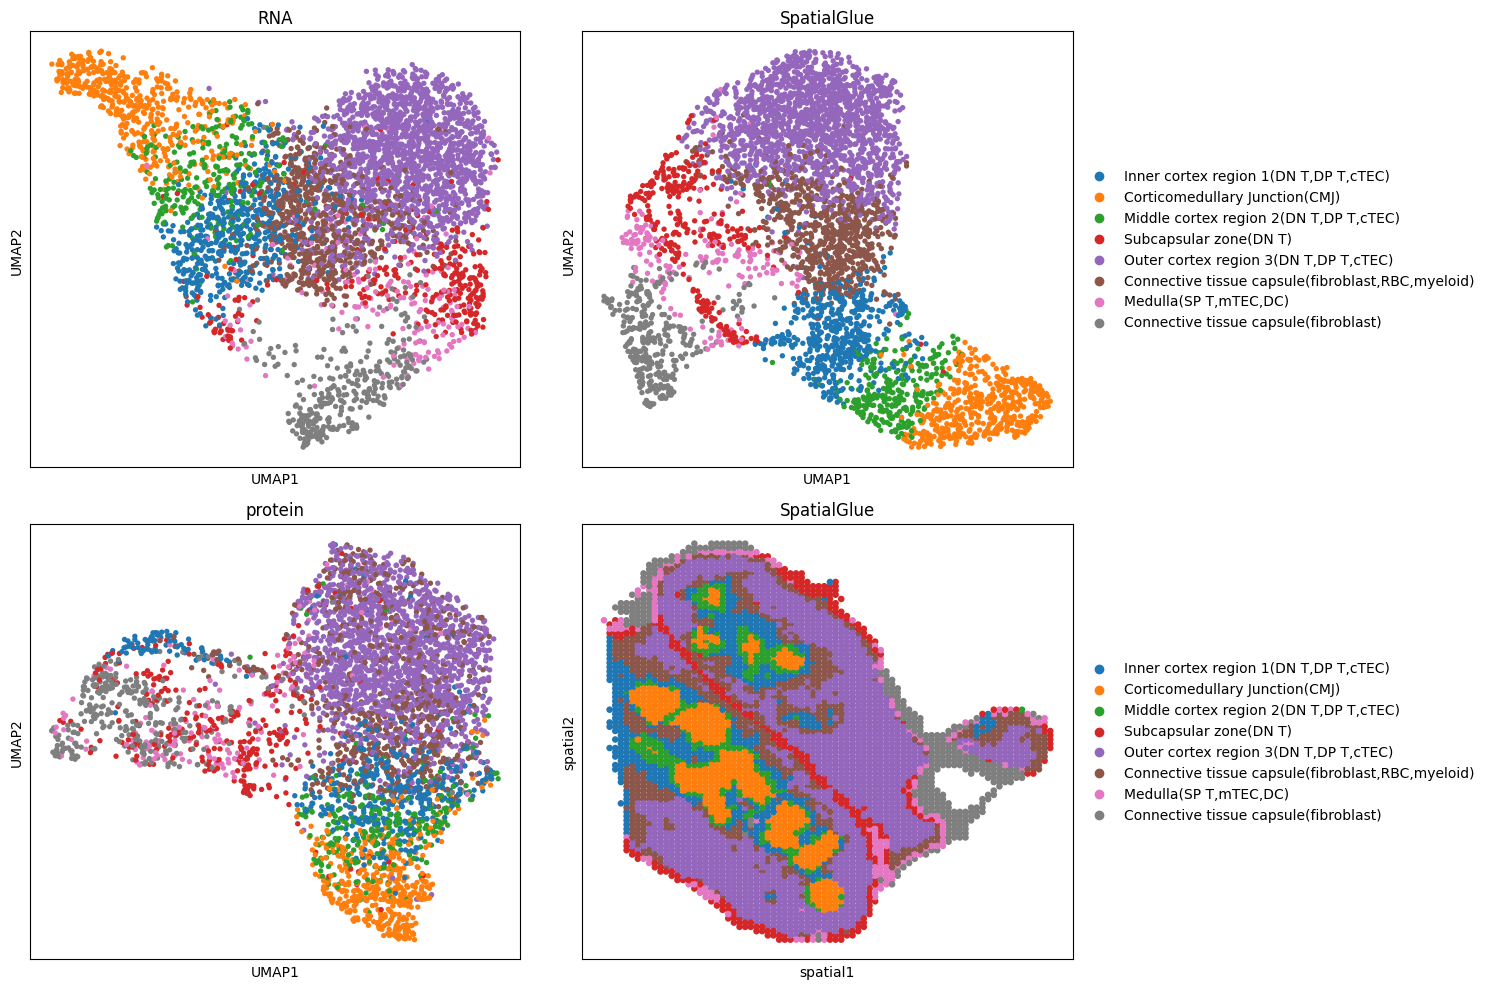

In [22]:
# joint plotting of raw and integrated data colored by SpatialGlue's lable
fig, ax_list = plt.subplots(2, 2, figsize=(15, 10))

adata_omics1.obs['SpatialGlue'] = adata_combined.obs['SpatialGlue'].copy()
adata_omics2.obs['SpatialGlue'] = adata_combined.obs['SpatialGlue'].copy()

sc.pl.umap(adata_omics1, color='SpatialGlue', ax=ax_list[0, 0], title='RNA', s=60, show=False)
sc.pl.umap(adata_omics2, color='SpatialGlue', ax=ax_list[1, 0], title='protein', s=60, show=False)

sc.pl.umap(adata_combined, color='SpatialGlue', ax=ax_list[0, 1], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SpatialGlue', ax=ax_list[1, 1], title='SpatialGlue', s=90, show=False)

ax_list[0, 0].get_legend().remove()
ax_list[1, 0].get_legend().remove()

plt.tight_layout(w_pad=3)
plt.show()

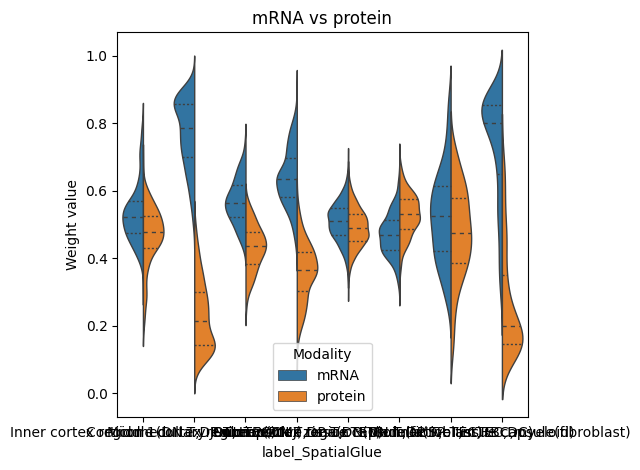

In [23]:
# plotting modality weight values
# To visualize the weight values of different modalities, we provide 'plot_weight_value' function.
from SpatialGlue.utils import plot_weight_value
plot_weight_value(output['alpha'], adata_combined.obs['SpatialGlue'].values)